<a href="https://colab.research.google.com/github/LucaForziati/car_price_prediction/blob/main/car_price_prediction_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciones

In [ ]:
pip install squarify

In [ ]:
# importaciones basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# missingno
import missingno as msno

# label encoder
from sklearn.preprocessing import LabelEncoder, PowerTransformer

# plotly
import plotly.graph_objects as go
import plotly.io as py
import plotly.express as px

# grafico treemap
import squarify

# separar el dataset
from sklearn.model_selection import train_test_split

# Transformacion
from sklearn.preprocessing import StandardScaler

# modelos y metricas
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()
LE = LabelEncoder()

In [ ]:
pd.set_option('display.max_columns', None)

# Cargar dataset

In [ ]:
# guardamos el link al dataset en una variable
url = "https://raw.githubusercontent.com/LucaForziati/car_price_prediction/main/dataset/CarPrice_Assignment.csv"

# creamos un pandas dataframe
car_prices = pd.read_csv(url)

In [ ]:
# visualizamos que el dataset se haya cargado correctamente
car_prices.head(2)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0


# Funciones

In [ ]:
# funcion que sea capaz de convertir las medidas
def convertir_unidades(unidad, dataset, columna):
  # convertir de pulgadas a cm
  if unidad == "cm":
    dataset[columna] = dataset[columna] * 2.54
  # convertir de pounds a kilogramo
  elif unidad == "kg":
    dataset[columna] = dataset[columna] * 0.453
  # convertir de millas por galon a kilometro por litro
  elif unidad == "kxl":
    dataset[columna] = dataset[columna] * 0.425
  # convertir de pulgadas cubicas a centimetros cubicos
  elif unidad == "cm2":
    dataset[columna] = dataset[columna] * 16.837

In [ ]:
def conversor_unidades(columnas_a_convertir, unidad, dataset):
  for columna in columnas_a_convertir:
    convertir_unidades(unidad, dataset, columna)

In [ ]:
# Funcion para transformar los valores no numericos a numericos y ademas crear un dataframe con los valores originales.

def valores_originales(dataset, columna):
  # Aplicar LabelEncoder a la columna
  transformed_columna = label_encoder.fit_transform(dataset[columna])

  # Obtener los valores originales
  original_columna = label_encoder.inverse_transform(transformed_columna)

  # Crear un nuevo DataFrame con las columnas originales y transformadas
  new_df = pd.DataFrame({"columna_original": original_columna, "columna_transformed": transformed_columna})

  unique_columna = new_df.drop_duplicates(subset="columna_transformed")
  dataset[columna] = LE.fit_transform(dataset[columna])
  return unique_columna

In [ ]:
def boxplots(dataset, columnas, c_filas, c_columnas, x_tamanio, y_tamanio, whis = [0.25, 0.75]):
  # crear el lienzo del grafico
  fig, axes = plt.subplots(nrows=c_filas, ncols=c_columnas, figsize=(x_tamanio, y_tamanio))



  # a y b será como recorrera el lienzo
  a = 0
  b = 0

  # recorrer las diferentes features y graficarlas
  for columna in columnas:

    # grafico
    ax = sns.boxplot(dataset, x=columna, ax=axes[a][b], whis = whis)
    ax.set_xlabel('')  # Eliminar el título por defecto del eje x
    axes[a][b].set_title(columna)  # Agregar título al subplot
    b +=  1
    if b == c_columnas:
      b = 0
      a += 1

  # Ajustar el espaciado entre subplots para evitar superposiciones
  plt.tight_layout()

  # Mostrar los subplots
  plt.show()

In [ ]:
def histplot(dataset, columnas, c_filas, c_columnas, x_tamanio, y_tamanio, bins):
  # crear el lienzo del grafico
  fig, axes = plt.subplots(nrows=c_filas, ncols=c_columnas, figsize=(x_tamanio, y_tamanio))

  # a y b será como recorrera el lienzo
  a = 0
  b = 0

  # recorrer las diferentes features y graficarlas
  for columna in columnas:
    ax = sns.histplot(dataset, x=columna, ax=axes[a][b], kde=True, bins = bins)
    ax.set_xlabel('')  # Eliminar el título por defecto del eje x
    axes[a][b].set_title(columna)  # Agregar título al subplot
    b +=  1
    if b == c_columnas:
      b = 0
      a += 1

  # Ajustar el espaciado entre subplots para evitar superposiciones
  plt.tight_layout()

  # Mostrar los subplots
  plt.show()

In [ ]:
# funcion para calcular la asimetria y la curtosis
def asimetria_curtosis(dataset, columnas, asimetria_maxima):
  # se establece un limite maximo para la curtosis.
  asimetria_limite = asimetria_maxima
  # se calcula la asimetria de las diferentes columnas
  calculo_asimetria = dataset[columnas].skew()
  # se devuelve una variable que contiene aquellas asimetrias que superan el limite deseado
  asimetria_columnas = calculo_asimetria[abs(calculo_asimetria)> asimetria_limite].sort_values(ascending=False)
  # se calcula la curtosis en base a las columnas que superan las el limite de asimetria
  curtosis = dataset[asimetria_columnas.index].kurt()

  # se almacenan los valores en un diccionario
  data = {'Asimetria': asimetria_columnas, 'Curtosis': curtosis}
  # se crea un dataset con los valores
  df = pd.DataFrame(data)
  # se devuelve el dataset
  return df

In [ ]:
def powerTransformer_asimetrias(dataset, columnas_transformar, metodo):
    # invoco a PowerTransformer y lo almaceno en una variable
    pt = PowerTransformer(method=metodo)
    dataset[columnas_transformar] = pt.fit_transform(dataset[columnas_transformar])
    return dataset, pt

In [ ]:
def cantidad_outliers(dataset, columnas, minimo, maximo, multiplicacion_iqr):
  outliers = {}
  for column in dataset[columnas]:
      Q1 = c_prices[column].quantile(minimo)
      Q3 = c_prices[column].quantile(maximo)
      IQR = Q3 - Q1

      # Definir los límites para los valores atípicos
      lower_bound = Q1 - multiplicacion_iqr * IQR
      upper_bound = Q3 + multiplicacion_iqr * IQR

      # Contar el número de valores atípicos en la columna
      outliers[column] = ((dataset[column] < lower_bound) | (dataset[column] > upper_bound)).sum()

  # Convertir el diccionario a un DataFrame
  outliers_df = pd.DataFrame(list(outliers.items()), columns=['Columna', 'Cantidad de Outliers'])

  return outliers_df

In [ ]:
def eliminar_outliers(dataset, columnas, minimo, maximo, multiplicacion_iqr):
  for column in dataset[columnas]:
      Q1 = c_prices[column].quantile(minimo)
      Q3 = c_prices[column].quantile(maximo)
      IQR = Q3 - Q1

      # Definir los límites para los valores atípicos
      lower_bound = Q1 - multiplicacion_iqr * IQR
      upper_bound = Q3 + multiplicacion_iqr * IQR

      # Eliminar las filas que contienen valores atípicos en la columna
      dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]

  return dataset

In [ ]:
def grafico_torta(dataset, columna, tamanio_x, tamanio_y, dataset_transformado = None):

  # Recupeando los datos
  valores = dataset[columna].value_counts()
  cantidades = dataset[columna].value_counts().tolist()

  # Recuperando los datos originales
  etiquetas = []

  etiquetas.append(dataset_transformado.loc[dataset_transformado['columna_transformed'] == valores.index[0], "columna_original"].iloc[0])


  # Colores
  colores = plt.rcParams['axes.prop_cycle'].by_key()['color']

  # Grafico 1
  plt.figure(figsize=(tamanio_x, tamanio_y))
  plt.pie(cantidades, labels=etiquetas, autopct='%1.2f%%', startangle=100, colors = colores)
  plt.title(f'{columna}')
  plt.axis('equal')  # Hace que el gráfico sea un círculo en lugar de una elipse
  plt.legend(title='Leyenda', loc='upper right', labels=etiquetas)
  plt.show()

In [ ]:
def grafico_torta(dataset, columna, dataset_transformado = None):

  # Recupeando los datos
  valores = dataset[columna].value_counts()
  cantidades = valores.tolist()

  # Recuperando los datos originales
  # se almacenan en una lista las etiquetas, es decir, los nombres
  etiquetas = []
  # en el caso que no se haya introducido un parametro para dataset_transformado
  # se almacenarán los valores diferentes valores que tenga la feature
  if (dataset_transformado is None):
    for i in range(valores.size):
      etiquetas.append(valores.index[i])
  # al realizar la transformacion de los datos de categoricos a numericos, se creo una variable que
  # los valores originales. Aca se recuperan para poder visualizarlos bien en el grafico
  else:
    for i in range(valores.size):
      etiquetas.append(dataset_transformado.loc[dataset_transformado['columna_transformed'] ==
                                                  valores.index[i], "columna_original"].iloc[0])


  # Crear el gráfico de torta con Plotly
  fig = go.Figure(data=[go.Pie(labels=etiquetas, values=cantidades, textinfo='percent+label')])

  # Ajustar el estilo del gráfico
  fig.update_layout(
      title={
          'text': columna,
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
      font=dict(
          family="Courier New, monospace",
          size=22,
          color="RebeccaPurple"
      ),
      paper_bgcolor='rgba(240,240,240,1)',
      plot_bgcolor='rgba(240,240,240,1)'
  )

  fig.show()

In [ ]:

def grafico_treemap(dataset, columna, dataset_transformado = None):

  # Recupeando los datos
  valores = dataset[columna].value_counts()
  cantidades = valores.tolist()

  # Recuperando los datos originales
  etiquetas = []
  if dataset_transformado is None:
    for i in range(valores.size):
      etiquetas.append(valores.index[i])
  else:
    for i in range(valores.size):
      etiquetas.append(dataset_transformado.loc[dataset_transformado['columna_transformed'] ==
                                                  valores.index[i], "columna_original"].iloc[0])

  # Crear el gráfico de treemap con Plotly
  fig = go.Figure(go.Treemap(
      labels=etiquetas,
      parents=[""]*len(etiquetas),
      values=cantidades,
      textinfo='label',
      hovertemplate='<b>%{label}</b><br>Cantidad: %{value}<extra></extra>',
      marker=dict(line=dict(width=0))
  ))

  # Ajustar el estilo del gráfico
  fig.update_layout(
      title={
          'text': columna,
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
      font=dict(
          family="Courier New, monospace",
          size=18,
          color="RebeccaPurple"
      ),
      paper_bgcolor='rgba(240,240,240,1)',
      plot_bgcolor='rgba(240,240,240,1)'
  )

  fig.show()


In [ ]:
def scatterplot(dataset, x, y):

  fig = px.scatter(dataset, x=x, y=y)

  # Agregamos un título al gráfico centrado
  fig.update_layout(title={'text': x + " vs " + y, 'x':0.5, 'xanchor': 'center'})

  # Agregamos etiquetas a los ejes
  fig.update_xaxes(title_text=x)
  fig.update_yaxes(title_text=y)

  fig.show()

# Data Wrangling

## Visualización de los datos crudos

### primera aproximación

In [ ]:
# visualizamos el tamaño del dataset
car_prices.shape

(205, 26)

El dataset cuenta con 205 registros y 26 columnas.

In [ ]:
# informacion general del dataset
car_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Se puede observar que algunas columnas no se encuentran en el tipo de dato adecuado para ser utilizado en un modelo de regresión de ML, ya que todos se deben encontrar en int o float.

Por otro lado, en una primera aproximación, el dataset no cuenta con datos nulos en ninguna de sus features.

In [ ]:
car_prices.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


A priori, se puede observar que casi todas las features numericas tienen una distribución normal; esto porque su media es muy similiar a la mediana. También se pueden visualizar outliers en algunas features como "curbweight" o "horsepower"; esto seria analizado con mayor enfasis en un futuro.

### datos nulos

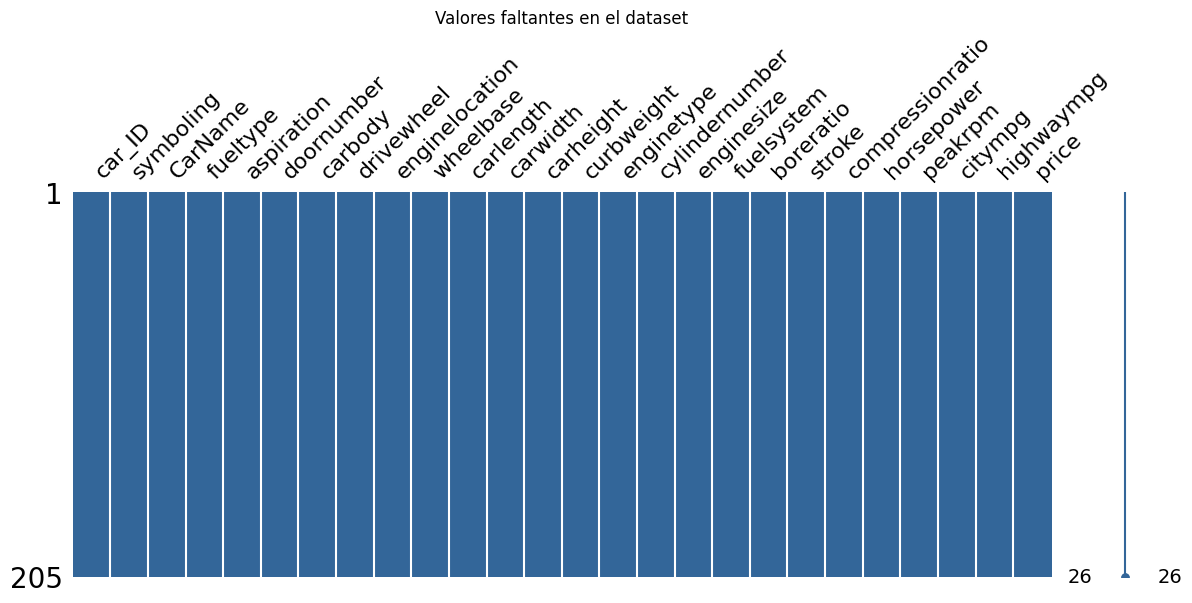

In [ ]:
# Utilizamos missingno para visualizar valores faltantes
matrix_ax = msno.matrix(car_prices, color=(0.2, 0.4, 0.6))
matrix_ax.set_title("Valores faltantes en el dataset")
current_fig = plt.gcf()
current_fig.set_size_inches(14, 5)

Utilizando la libreria especializada de missingno, podemos confirmar lo observado anteriormente; el dataset no cuenta con valores nulos.

### valores repetidos

In [ ]:
# Visualizamos si hay datos repetidos utilizando la funcion duplicate
valores_duplicados = car_prices.duplicated()
valores_duplicados.value_counts()

False    205
dtype: int64

Obsevamos que la función devuelve "false"; por lo tanto, parecería que el dataset no cuenta con valores repetidos. Sin embargo, para confirmar esto, procederé a evaluar si no existen IDs repetidos.

In [ ]:
identico_id = car_prices["car_ID"]
car_prices[identico_id.isin(identico_id[identico_id.duplicated()])].sort_values("car_ID")

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


Al no devolver nada, podemos concluir que no hay valores repetidos en el dataset.

## Transformando el dataset

### copiar dataset

In [ ]:
# con la finalidad de conservar la integridad del dataset original, procedemos a realizar una copia del mismo para realizar transformaciones
c_prices = car_prices.copy()

### eliminar columnas que no son de interes

In [ ]:
c_prices = c_prices.drop("CarName", axis=1)

Se considera que el nombre del vehiculo no aporta poder predictivo al modelo.

### establecer como indice al ID

In [ ]:
# Establecer la columna ID como indice.
c_prices.set_index('car_ID', inplace=True)

### transformar datos no numericos a numericos


Algunas columnas del dataset son de tipo "object"; por lo tanto, hay que realizar una transformación para poder utilizarlas en el modelo de ML.

Para ello, utilizaremos labelEncoder.

In [ ]:
# declaramos en un array las features que se van a transforar utilizando labelEncoder
features_no_numericas = ["fueltype", "aspiration", "carbody", "drivewheel", "enginelocation", "enginetype", "fuelsystem"]

# creamos un dataframe por cada feature. El mismo guarda el valor original junto con su valor numerico asignado.
fueltype_transformado = valores_originales(c_prices, features_no_numericas[0])
aspiration_transformado = valores_originales(c_prices, features_no_numericas[1])
carbody_transformado = valores_originales(c_prices, features_no_numericas[2])
drivewheel_transformado = valores_originales(c_prices, features_no_numericas[3])
enginelocation_transformado = valores_originales(c_prices, features_no_numericas[4])
enginetype_transformado = valores_originales(c_prices, features_no_numericas[5])
fuelsystem_transformado = valores_originales(c_prices, features_no_numericas[6])

Restan transformar dos features que no se encuentran en el tipo de dato deseado. Estas dos no fueron transformadas utilizando LabelEncoder porque son numeros escritos en letras. Por lo tanto, queremos que el valor sea identico.

In [ ]:
# visualizamos cuales son los registros unicos que cuenta la feature "doornumber".
c_prices["doornumber"].unique()

array(['two', 'four'], dtype=object)

La feature doornumber representa la cantidad de puertas que posee el vehiculo. Cuenta con dos valores unicoas: "two"; "four". Se procederá a pasar a numero dichos valores utilizando la funcion de pandas replace.

In [ ]:
# mediante replace reemplazamos los valores deseados.
c_prices["doornumber"] = c_prices["doornumber"].replace({"two": 2, "four": 4})

In [ ]:
c_prices["cylindernumber"].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

La feature cylindernumber representa la cantidad de cilindros que posee un vehiculo. Cuenta con varios registros como: 'four', 'six', 'five', 'three', 'twelve', 'two', 'eight'. Se realizará un metodo similar al anterior.

In [ ]:
cylindernumber_a_transformar = {
    "four": 4,
    "six": 6,
    "five": 5,
    "three": 3,
    "twelve": 20,
    "two": 2,
    "eight": 8
}
c_prices["cylindernumber"] = c_prices["cylindernumber"].replace(cylindernumber_a_transformar)

Para verificar que todos los features se encuentran en el tipo de deseado se utilizará nuevamente la funcion info

In [ ]:
c_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    int64  
 2   aspiration        205 non-null    int64  
 3   doornumber        205 non-null    int64  
 4   carbody           205 non-null    int64  
 5   drivewheel        205 non-null    int64  
 6   enginelocation    205 non-null    int64  
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    int64  
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    int64  
 16  boreratio         205 non-null    float64
 1

## Distribución de los datos

### boxplot

In [ ]:
columnas_analizar_boxplot = ["wheelbase", "carlength", "carwidth", "carheight", "curbweight",
                             "enginesize", "boreratio", "stroke", "compressionratio", "horsepower", "peakrpm",
                             "citympg", "highwaympg", "price"]

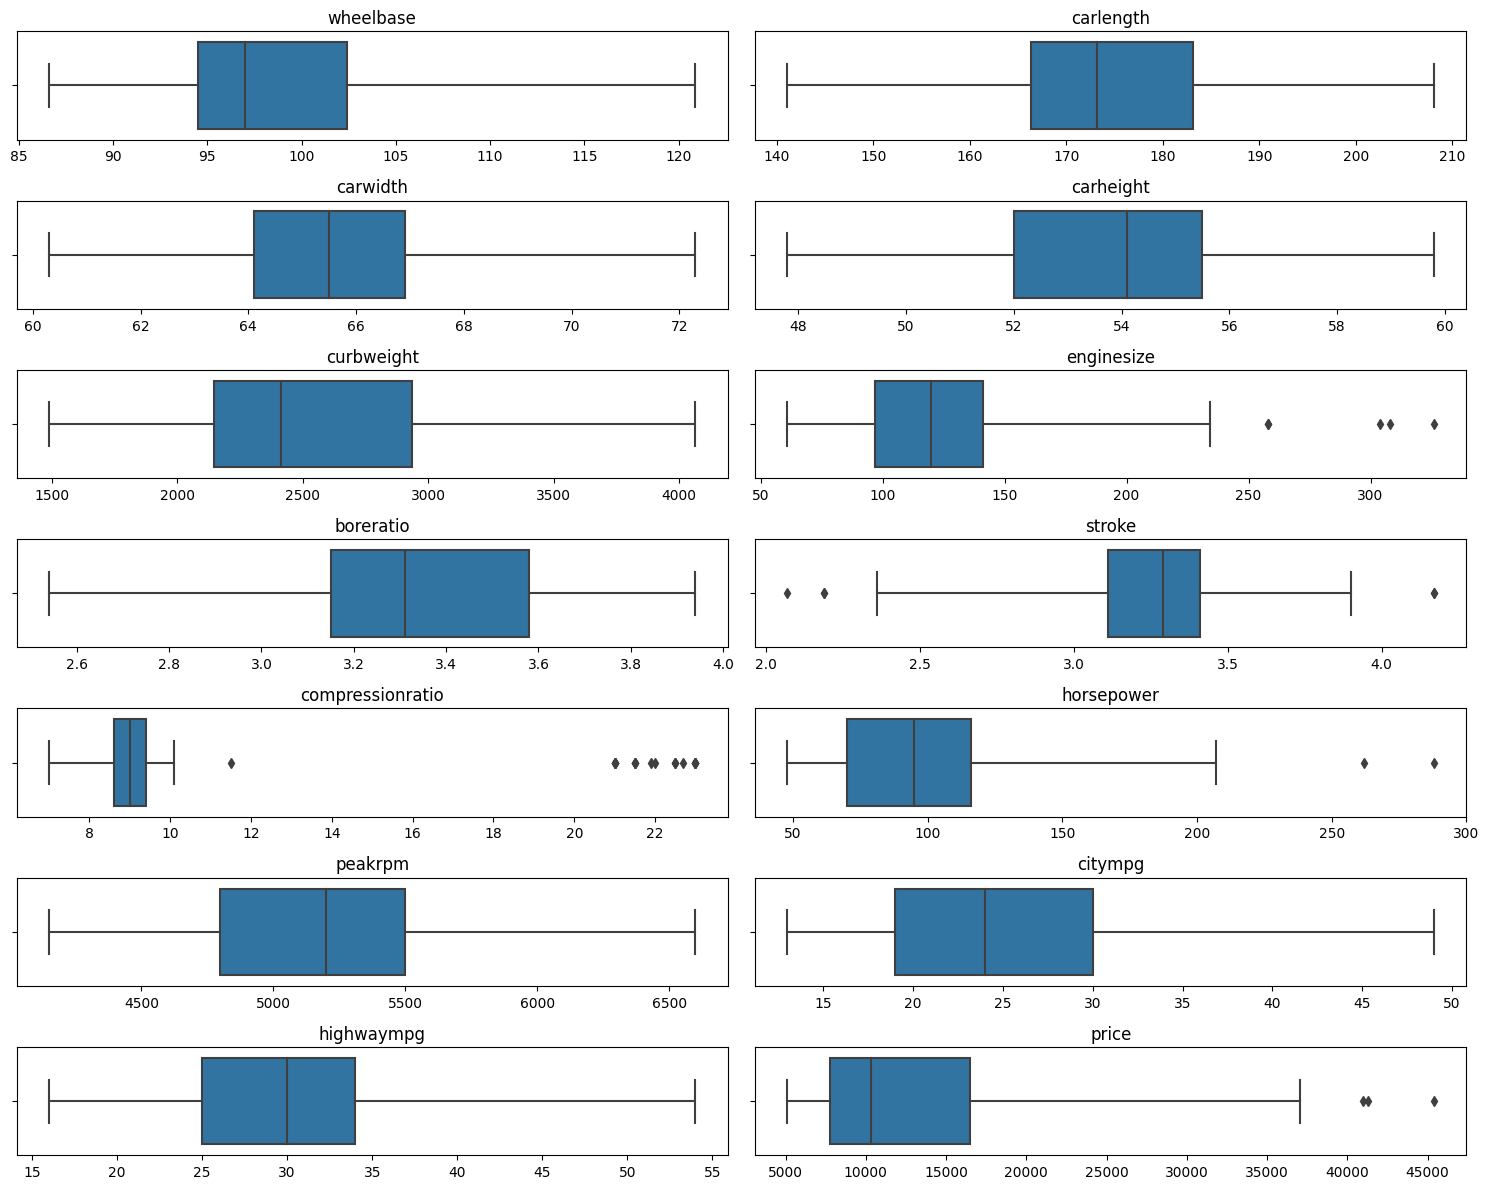

In [ ]:
boxplots(c_prices, columnas_analizar_boxplot, 7, 2, 15, 12, 2.5)

In [ ]:
cantidad_outliers(c_prices, columnas_analizar_boxplot, 0.25, 0.75, 2.5)

,Columna,Cantidad de Outliers
0,wheelbase,0
1,carlength,0
2,carwidth,0
3,carheight,0
4,curbweight,0
5,enginesize,5
6,boreratio,0
7,stroke,5
8,compressionratio,21
9,horsepower,2


In [ ]:
"""
c_prices = eliminar_outliers(c_prices, columnas_analizar_boxplot, 0.25, 0.75, 2.5)
"""

'\nc_prices = eliminar_outliers(c_prices, columnas_analizar_boxplot, 0.25, 0.75, 2.5)\n'

Eliminar todos los outliers del dataset significaria quedarse sin vehiculos que su combustible sea diesel, lo cual resulta de importancia para el presente proyecto.

### distribucion

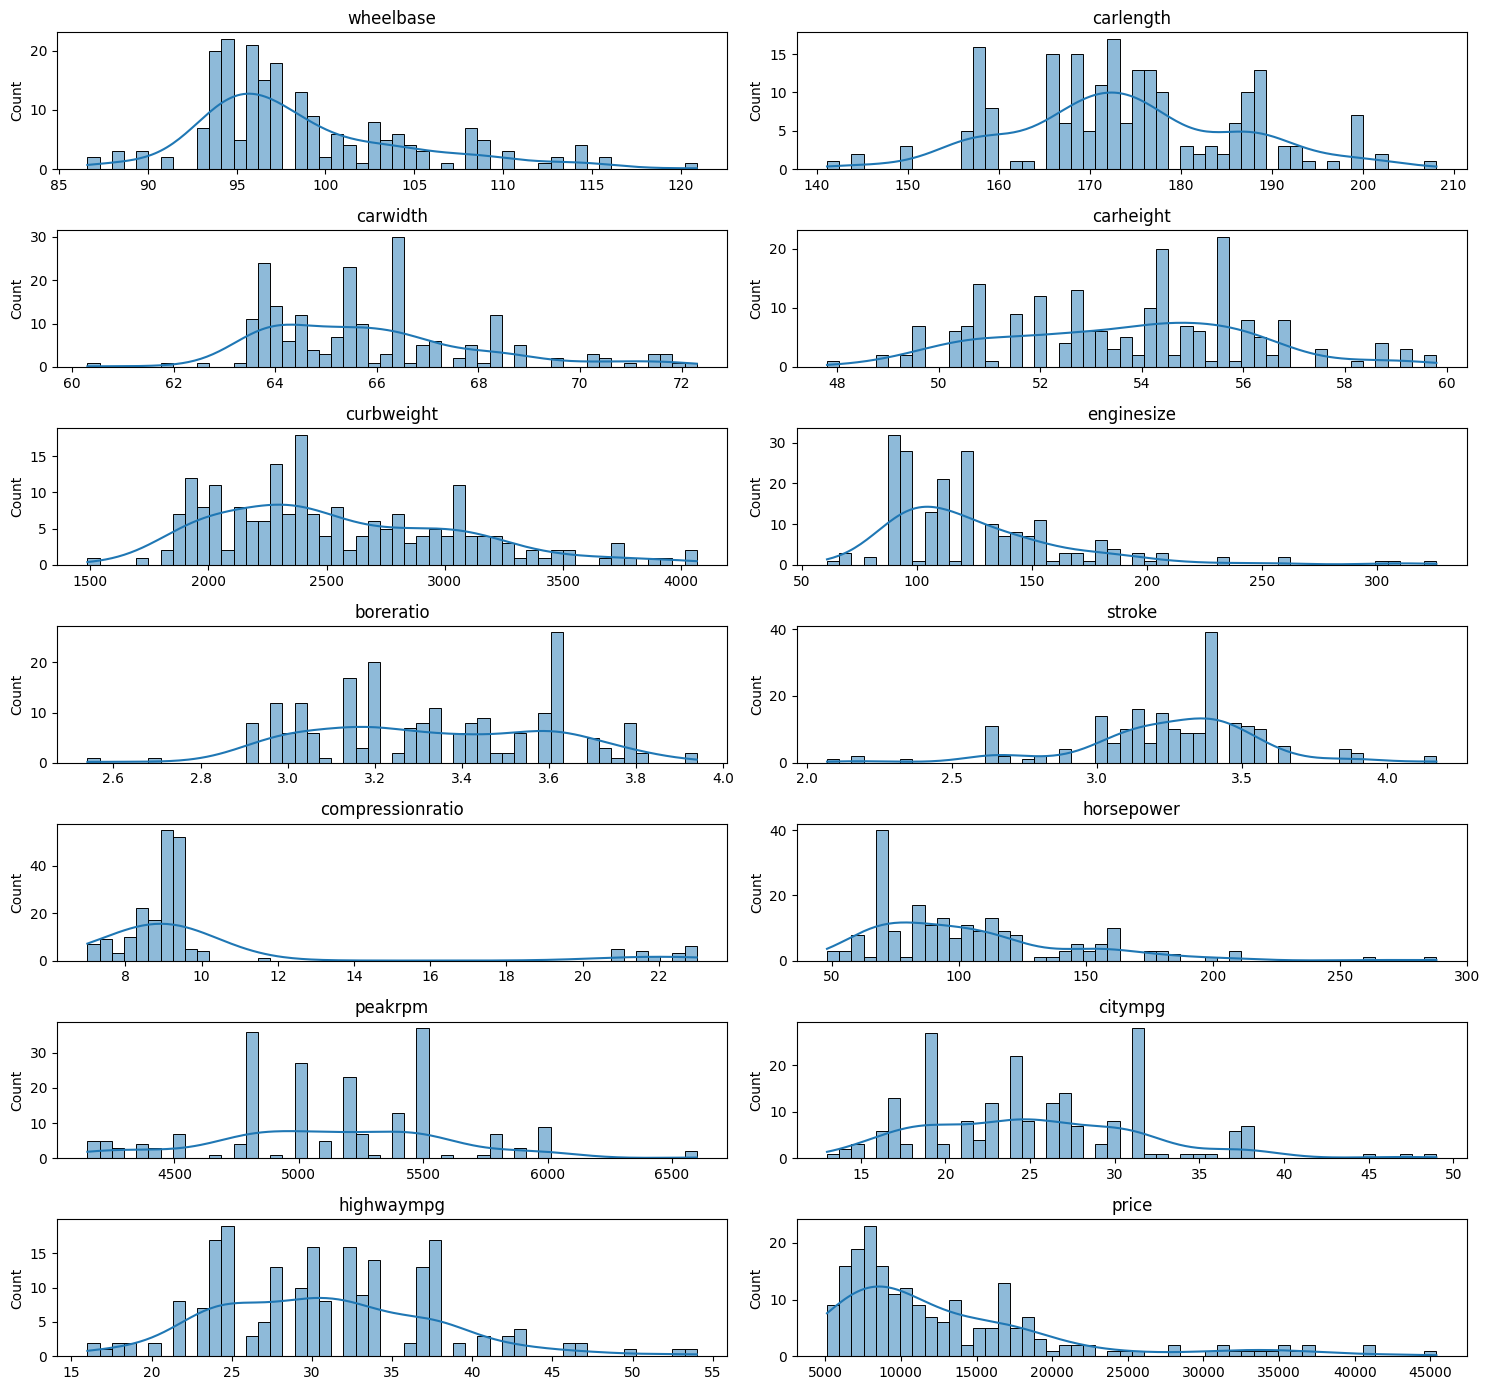

In [ ]:
histplot(c_prices, columnas_analizar_boxplot, 7, 2, 15, 14, 50)

In [ ]:
c_prices.shape

(205, 24)

In [ ]:
columnas_con_asimetria = asimetria_curtosis(c_prices, columnas_analizar_boxplot, 0.75)
columnas_con_asimetria

,Asimetria,Curtosis
compressionratio,2.610862,5.233054
enginesize,1.947655,5.305682
price,1.777678,3.051648
horsepower,1.405310,2.684006
wheelbase,1.050214,1.017039
carwidth,0.904003,0.702764


Se puede observar que las diferentes features cuentan con asimetrias superiores al valor deseado que es 0.75. Por ello se le dará el tratamiento adecuado.

Es importante mencionar que la funcion invocada transforma los valores a absolutos. Por lo tanto, esto no significa que estemos en presencia de asimetrias positivas o negativas, simplemente son asimetrias.

In [ ]:
#columnas_con_asimetria.drop('price', inplace=True)

In [ ]:
# powerTransformer_asimetrias(c_prices, columnas_con_asimetria.index, "yeo-johnson")

In [ ]:
#c_prices[columnas_con_asimetria.index].skew()

In [ ]:
#c_prices[columnas_con_asimetria.index].kurt()

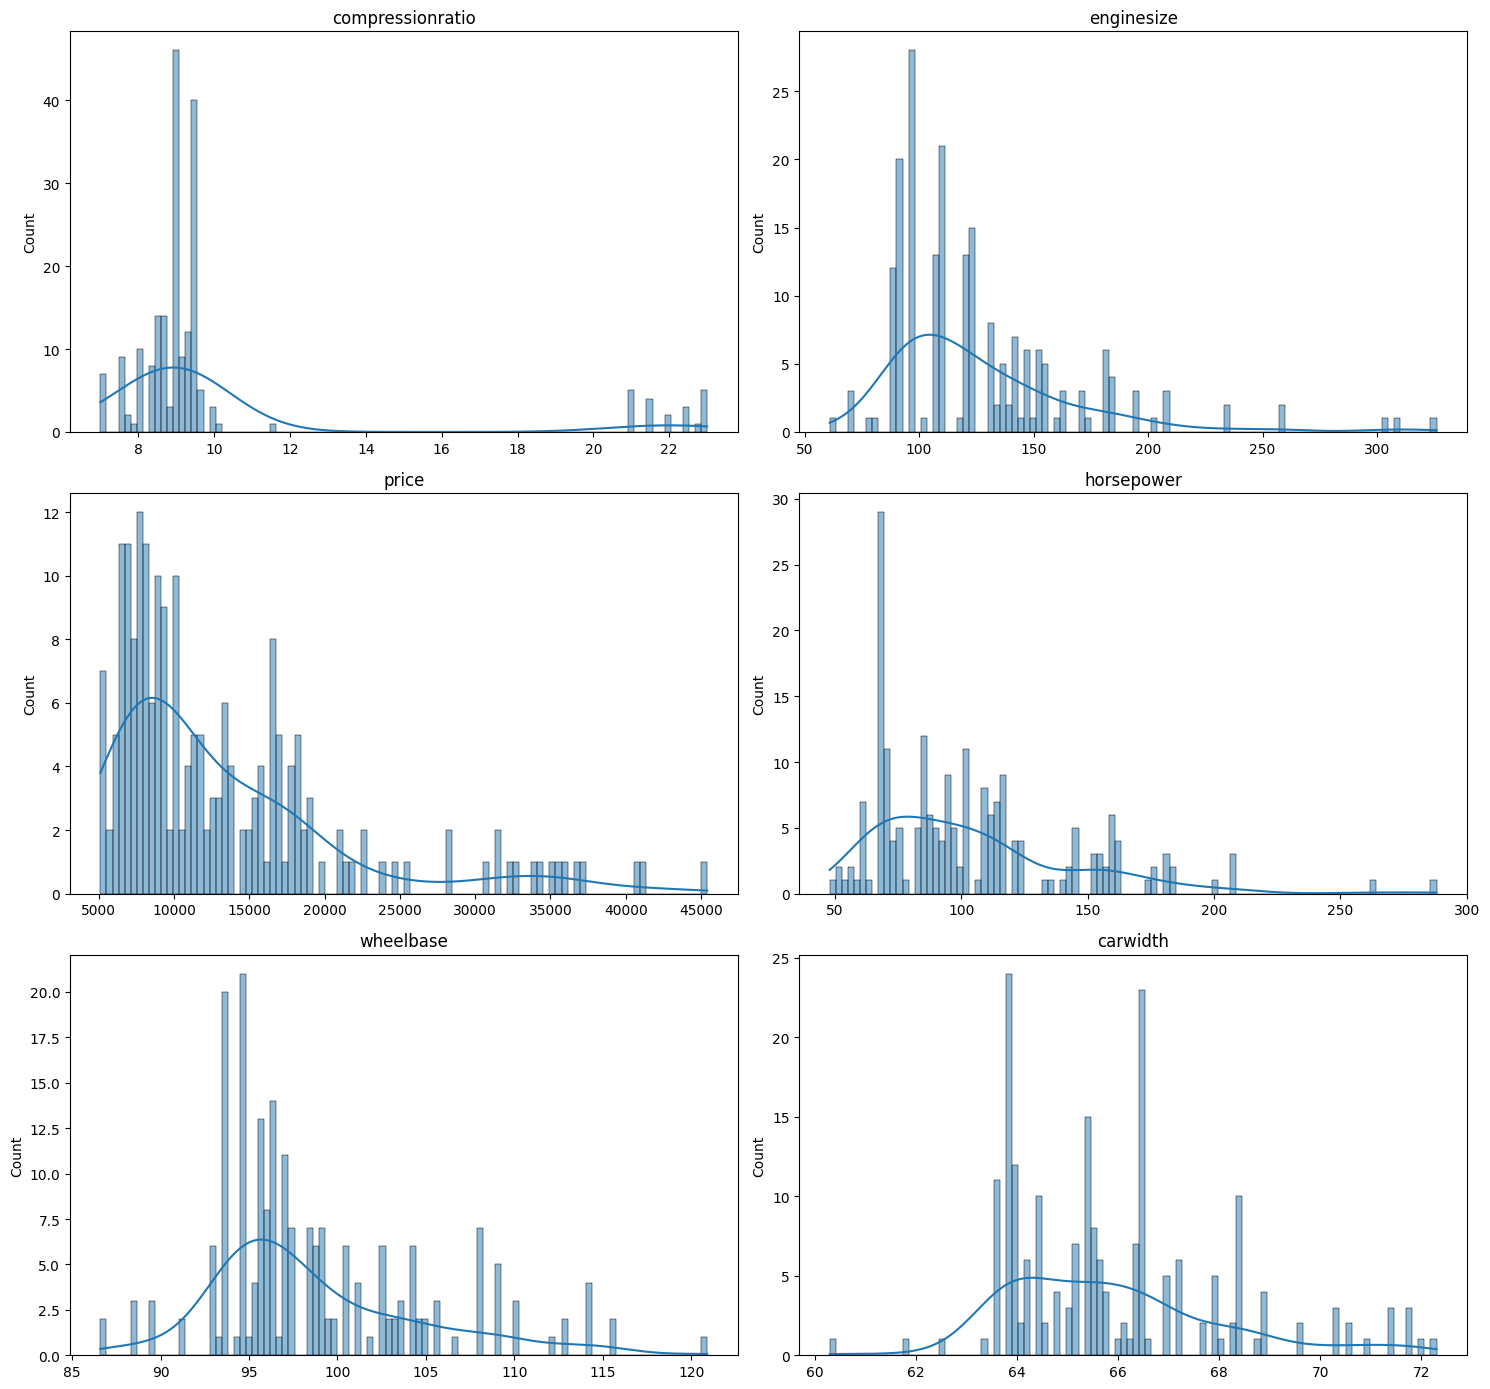

In [ ]:
histplot(c_prices, columnas_con_asimetria.index, 3, 2, 15, 14, 100)

# EDA

## Univariado

In [ ]:
grafico_torta(c_prices, "fueltype", fueltype_transformado)

In [ ]:
grafico_torta(c_prices, "doornumber")

In [ ]:
grafico_treemap(c_prices, 'symboling')

In [ ]:
grafico_treemap(c_prices, 'cylindernumber')

In [ ]:
grafico_treemap(c_prices, 'enginetype', enginetype_transformado)

In [ ]:
"""
# Seleccionar los dos géneros y las características deseadas
genero1 = "Precios"
caracteristicas = c_prices.columns

# Calcular la mediana de las características para cada género
medianas = c_prices[caracteristicas].median()

# Crear una lista circular para las características
caracteristicas_circular = caracteristicas + [caracteristicas[0]]

# Ajustar los valores para que coincidan con las etiquetas
medianas_circular = np.append(medianas, medianas[0])

# Calcular el ángulo para cada característica
angulos = np.linspace(0, 2 * np.pi, len(caracteristicas_circular), endpoint=False).tolist()
angulos.append(angulos[0])  # Añadir un ángulo extra al final

# Crear un gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angulos, medianas_circular, color='orangered', alpha=0.5, label=genero1)
ax.fill(angulos, medianas_circular, color='orangered', alpha=0.25)

ax.set_title(f'Gráfico de radar - {genero1}', weight='bold', fontsize=12)
ax.legend()

# Configurar el rango y las etiquetas del gráfico de radar
ax.set_ylim(0, 1)
ax.set_yticklabels([])
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(caracteristicas, fontsize=8)
"""

'\n# Seleccionar los dos géneros y las características deseadas\ngenero1 = "Precios"\ncaracteristicas = c_prices.columns\n\n# Calcular la mediana de las características para cada género\nmedianas = c_prices[caracteristicas].median()\n\n# Crear una lista circular para las características\ncaracteristicas_circular = caracteristicas + [caracteristicas[0]]\n\n# Ajustar los valores para que coincidan con las etiquetas\nmedianas_circular = np.append(medianas, medianas[0])\n\n# Calcular el ángulo para cada característica\nangulos = np.linspace(0, 2 * np.pi, len(caracteristicas_circular), endpoint=False).tolist()\nangulos.append(angulos[0])  # Añadir un ángulo extra al final\n\n# Crear un gráfico de radar\nfig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))\nax.plot(angulos, medianas_circular, color=\'orangered\', alpha=0.5, label=genero1)\nax.fill(angulos, medianas_circular, color=\'orangered\', alpha=0.25)\n\nax.set_title(f\'Gráfico de radar - {genero1}\', weight=\'bold\', fo

## Multivariado

[Text(0.5, 0, 'symboling'),
 Text(1.5, 0, 'fueltype'),
 Text(2.5, 0, 'aspiration'),
 Text(3.5, 0, 'doornumber'),
 Text(4.5, 0, 'carbody'),
 Text(5.5, 0, 'drivewheel'),
 Text(6.5, 0, 'enginelocation'),
 Text(7.5, 0, 'wheelbase'),
 Text(8.5, 0, 'carlength'),
 Text(9.5, 0, 'carwidth'),
 Text(10.5, 0, 'carheight'),
 Text(11.5, 0, 'curbweight'),
 Text(12.5, 0, 'enginetype'),
 Text(13.5, 0, 'cylindernumber'),
 Text(14.5, 0, 'enginesize'),
 Text(15.5, 0, 'fuelsystem'),
 Text(16.5, 0, 'boreratio'),
 Text(17.5, 0, 'stroke'),
 Text(18.5, 0, 'compressionratio'),
 Text(19.5, 0, 'horsepower'),
 Text(20.5, 0, 'peakrpm'),
 Text(21.5, 0, 'citympg'),
 Text(22.5, 0, 'highwaympg'),
 Text(23.5, 0, 'price')]

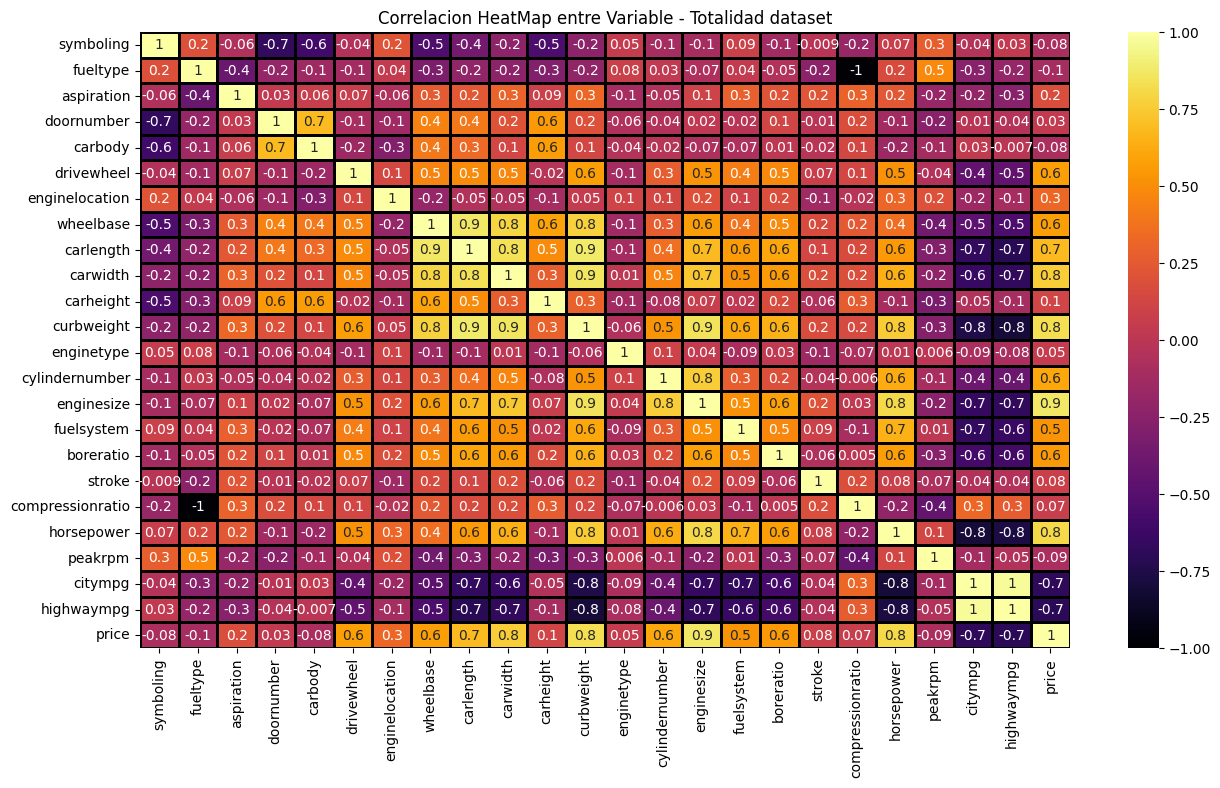

In [ ]:
# Grafico de correlación entre las features
plt.figure(figsize=(15,8))

heatmap = sns.heatmap(c_prices.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1,cmap ='inferno', center=0, linewidths=1, linecolor="Black")
heatmap.set_title("Correlacion HeatMap entre Variable - Totalidad dataset")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)

Correlación inversa entre highwaympg y horsepower

Correlacion inversa entre citympg y horsepower

Correlacion perfecta entre citympg y highwaympg

Correlacion inversa entre citympg y curbweight

carlength

## Bivariado

In [ ]:
scatterplot(c_prices, "citympg", 'horsepower')

In [ ]:
scatterplot(c_prices, "citympg", 'highwaympg')

In [ ]:
scatterplot(c_prices, "citympg", 'curbweight')

In [ ]:
scatterplot(c_prices, "highwaympg", 'horsepower')

# Preparar el dataset

In [ ]:
c_prices_final = c_prices.copy()

In [ ]:
c_prices_final = c_prices_final.drop("highwaympg", axis=1)
c_prices_final = c_prices_final.drop("citympg", axis=1)
c_prices_final = c_prices_final.drop("carlength", axis=1)
c_prices_final = c_prices_final.drop("curbweight", axis=1)

In [ ]:
c_prices_final.head(5)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carwidth,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price
car_ID,,,,,,,,,,,,,,,,,,,,
1,3,1,0,2,0,2,0,88.6,64.1,48.8,0,4,130,5,3.47,2.68,9.0,111,5000,13495.0
2,3,1,0,2,0,2,0,88.6,64.1,48.8,0,4,130,5,3.47,2.68,9.0,111,5000,16500.0
3,1,1,0,2,2,2,0,94.5,65.5,52.4,5,6,152,5,2.68,3.47,9.0,154,5000,16500.0
4,2,1,0,4,3,1,0,99.8,66.2,54.3,3,4,109,5,3.19,3.40,10.0,102,5500,13950.0
5,2,1,0,4,3,0,0,99.4,66.4,54.3,3,5,136,5,3.19,3.40,8.0,115,5500,17450.0


## Escalar dataset

En este paso escalaremos nuestro conjunto de datos. Existen varias formas para realizar esto; sin embargo, en este caso particular utilzaré StandardScaler de Sklearn.

Pero bien, ¿que significa escalar?. Se busca cambiar el rango para que se encuentren en un ambito común; esto se hace para facilitar el análisis y el procesamiento de los datos. Si, por ejemplo, poseemos dos features, una cuyo valores se mueven en un rango de 1000 a 10000 y otra que se mueve entre 10 y 20; esto puede traer complicaciones a la hora de entrenar el modelo. Por lo tanto, mediante la estandarización se busca solucionar este problema y otros.

Veamos su formula:

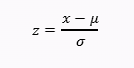

Sus parametros son:

X -> valor observado

u -> media

alpha -> desviacion estandar

A su vez, esta formula es la de Z-score que significa tomar el valor real, restarle la media y todo ello dividirlo por la desviacion estandar.

In [ ]:
# Crear una instancia del escalador StandarScaler
scaler = StandardScaler()

# seleccionamos las columnas a transformar
columnas_a_transformar = c_prices_final.columns

# Ajustar y transformar las columnas
for i in columnas_a_transformar:
  c_prices_final[i] = scaler.fit_transform(c_prices_final[[i]])

In [ ]:
c_prices_final.head(3)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carwidth,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price
car_ID,,,,,,,,,,,,,,,,,,,,
1,1.743470,0.328798,-0.469295,-1.130388,-3.050975,1.21333,-0.121867,-1.690772,-0.844782,-2.020417,-2.865105,-0.291728,0.074449,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.26296,0.027391
2,1.743470,0.328798,-0.469295,-1.130388,-3.050975,1.21333,-0.121867,-1.690772,-0.844782,-2.020417,-2.865105,-0.291728,0.074449,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.26296,0.404461
3,0.133509,0.328798,-0.469295,-1.130388,-0.717207,1.21333,-0.121867,-0.708596,-0.190566,-0.543527,1.886890,1.099069,0.604046,0.869568,-2.404880,0.685946,-0.288349,1.264536,-0.26296,0.404461


Como pueden ser interpretados estos valores? Lo que devuelve el StandardScaler es a cuantas desviaciones estandar se encuentre de la media la observación. Es decir, tomemos como ejemplo la columna "carwidth" del auto con id 3, este valor es -0,098...; esto quiere decir que ese valor en particular se encuentra a -0.098 desviaciones estandar de la media.

Un dato importante es que, cuando el valor devuelto es negativo significa que se encuentra a la izquierda de la media. Si el valor es positivo, significa que se encuentra a la derecha de la media.

## separando el dataset

In [ ]:
#Separación en Train y Test
X = c_prices_final.drop("price", axis=1) # Almacenamos en la variable X el dataset sin con el precio
y = c_prices_final['price'] # Almacenamos en la variable la feature con el precio

In [ ]:
# Separamos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Modelos

## metricas almacenadas

In [ ]:
# Metricas obtenidas por los modelos
metricas_sn1 = {
    'rmse': [],
    'r2': []
}

Esta creará un espacio con n dimensiones(dependiendo de la cantidad de features) y a partir de ello generará un hiperplano que será el que mejor se ajuste al conjunto de datos.

Para evaluar el desempeño de los diferentes modelos se utilizarán 2 metricas:

a) R2

b) RMSE


### R2

El coeficiente de determinación, mas conocido como R2, es una de las metricas mas utilizadas para problemas de regresión. Esta mide la proporción de varianza de la variable dependiente explicada por la variable (s) independiente. De forma mas sencilla, que tanto explica nuestro conjunto de datos la feature objetivo.

Veamos como es su formula:




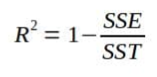

El R2 podemos calcularlo como 1 menos la división entre el "Error de sumas de cuadrados" y "Suma de cuadrados totales". Pero, ¿que son estos valores? ¿De donde surgen?. Veamos sus formulas

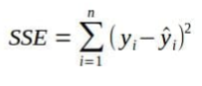

El primer termino dentro del parentesis representa el valor observado o real del dataset; mientras que el segundo termino representa el valor predicho. Por lo tanto, SSE es la suma de los cuadrados de las diferencias entre cada valor observado y su correspondiente valor predicho.

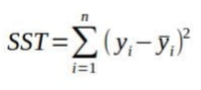

El primer termino dentro del parentesis representa el valor observado o real del dataset; mientras que el segundo termino representa la media de la variable objetivo. Por lo tanto, SST es la suma de los cuadrados de las diferencias entre cada valor observado y su correspondiente media.

Una vez obtenidos estos valores, es posible calcular el R2. Ahora bien, ¿como se interpretan sus valores?

Los resultados estaran entre el rango de 0 y 1. ¿Esto que representa?

0 -> nuestro modelo no explica en nada a nuestra variable objetivo.

1 -> nuestro modelo explica a la perfeccion a nuestra variable objetivo.

Es importante mencionar que un R2 igual a 1 no significa que debamos quedarnos tranquilos; es mas, es todo lo contrario, deberiamos preocuparnos ya que el modelo podria estar sobreajustando en algun sitio.



Uno de los inconvenientes que tiene R2 es que el valor puede aumenta falsamente a medida que se agregan mas variables independientes a los modelos. Esto se debe a que cada vez que agregas una nueva variable al modelo, estás añadiendo una nueva dimensión que complejiza el modelo y le puede permiter ajustarse de mejor manera a los datos. Si repasamos la formula de R2, esto significa que el error de sumas de cuadrados es menor, por lo tanto el valor se encuentra mas cercano a 1. Esto no necesariamente significa algo bueno, ya que nuestro modelo podria estar sobreajustandose, lo cual trae problemas a futuro.


### RMSE

Esta metrica es tambien una de las mas utilizadas y viene a solucionar uno de los grandes problemas que tiene la metrica "error cuadrado medio" (MSE), que es el cambio de unidad.

Ahora bien, ¿que es MSE? Veamos su formula:



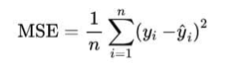

Primero, entedamos sus indices.

**n** -> numero total de observaciones.

**yi**(primer termino parentesis) -> valor observado.

**y^i**(segundo termino parentesis) -> es el valor predicho.

Por lo tanto, lo que realiza esta metrica es cualcula la sumatoria de los cuadrados de la diferenia entre el valor real y el valor predicho. A este valor lo divide entre la cantidad total de observaciones.

Esta metria posee dos grandes problemas: por un lado, al elevar al cuadrado magnifica el error; por otro lado, al elevar al cuadrado cambia la unidad. Por ejemplo, la estatura de una persona quedaria en m2, lo cual no tiene mucho sentido.

Para solucionar dichos problemas surge RMSE.

Esta metrica lo que hace es le agrega una raiz cuadrada a todo para volver a recuperar la unidad original. Veamos su formula:

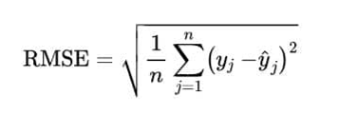

¿Como podemos interpretar los valores devueltos por esta metrica? Vamos a buscar que sea lo mas cercana a 0 posible; cuando menor sea el valor, mejor será el modelo de regresion.



## explicación

Para resolver el presente proyecto se utilzará como modelo de aprenziaje la regresión lineal. Ahora bien, ¿que es la regresión lineal?

Es un algoritmo de aprendizaje automatico supervisado que busca encontrar una relación lineal entre una o más variables independientes y una variable dependiente. De forma mas sencilla, busca predecir el valor de una feature numerica a partir de otra u otras.

### regresión lineal simple

En la regresión lineal simple contamos con dos features(columnas): a) una variable dependiente; b) una variable independiente. Se buscará, a través de esta ultima, predecir el valor de la primera. Un ejemplo sencillo seria predecir el peso de una persona(variable dependiente) a partir de su altura(variable independiente).

Veamos su formula:

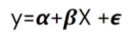

Esta es la formula de una función lineal, agregandole epsilon.

¿Que representa cada termino?:

**y** = variable dependiente. Es decir, el valor que se busca predecir.

**alpha** = intercepto u ordenada al origen. Es decir, valor que toma y cuando X = 0

**beta** = pendiente. Indica como cambia y al incrementar X.

**epsilon** = representa el error aleatorio con una distribución normal.

Ahora bien, ¿como puedo hallar una recta que explique de la mejor manera a mi dataset? En general, esto se resuelve con pocas lineas de codigo; sin embargo, resulta interesante saber cual es su procedimiento.

Las siguientes imagenes que utilizaré pertenecen al canal de youtube "StatQuest with Josh Starmer" que cuenta con varios videos explicando de forma detallada todos estos topicos. Link a su canal: https://www.youtube.com/@statquest

Como mencionamos, vamos a buscar una recta que se "acomode" de la mejor manera a nustros datos. ¿Como vamos a lograr esto? ¡Probando diferentes rectas!

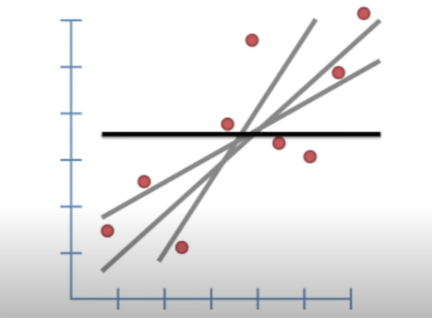

Podemos observar que la linea horizontal no explica muy bien los datos; esto porque si hacemos incapie en, por ejemplo, el primer punto(de izquierda a derecha y de arriba hacia abajo) se encuentra muy alejando de la recta; misma situacion con el ultimo punto.

Aquellas rectas que cuentan con algun grado de pendiente parece que se ajustan mejor a nuestros datos. Pero, ¿como hallar la mejor? ¿esta eleccion es simplemente a ojo? La respuesta es que no. Aca es donde entra en juego el metodo de sum of squared residuals o suma de cuadrados residuales.

¿Que es un residual? De forma sencilla podemos entenderlo como la distancia que hay entre el valor real y la recta.

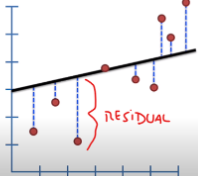

Por lo tanto, calcularemos cada residual y luego sumaremos uno por uno. Esto es una formula que ya vimos en el apartado de metricas:

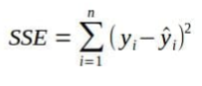

Vamos a buscar que la suma de cuadrados residuales sea lo menor posible; aquella recta que cumpla esta condición será la elegida.

Como mencioné al principio todo este procedimiento se realiza con muy pocas lineas de codigo.

### regresion lineal multiple

La regresión lineal multiple funciona de manera casi similar a la simple; solo que, en este caso, en vez de tener una variable independiente vamos a tener 2 o mas. Esto significa agregarle dimensiones a nuestro problema que muchas veces resulta dificil de visualizar o imaginar.

Ahora ya no buscaremos una recta, sino un plano o hiperplano dependiendo con cuantas features estemos trabajando.

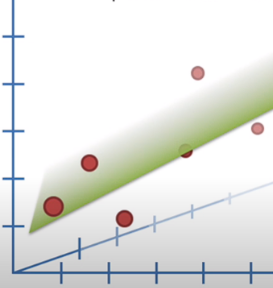

Veamos como es su formula:

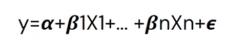

Ahora contamos con mas terminos-tantos como variables independientes-, siendo "n" la cantidad de features.

Luego los procedimientos son similiares a los de la regresión lineal simple. Se buscará mediante la suma de cuadrados residuales hallar aquel plano o hiperplano que mejor se acople a nuestros datos.

En la regresión lineal multiple toma mucha relevancia el concepto de significatividad individual. Esto podemos entenderlo como la relevancia o importancia que tiene una variable independiente para explicar la variable dependiente. Si beta n es cero o muy cercano a cero, significará que esa feature no afecta significativamente al valor de la varible dependiente; por lo tanto, podriamos eliminarla de nuestro dataset sin afectar en gran escala el poder de predicción del modelo.

## regresion lineal

Como nuestro dataset tiene varias variables independientes utilizaremos la regresión lineal multiple.

In [ ]:
# declaramos en una variable el modelo
model = LinearRegression()

# mediante el metodo .fit entrenamos a nuestro modelo con los datos de entrenamiento.
model.fit(X_train, y_train)

# utilizamos el metodo .predict para predecir los valores de la variable dependiente a partir de los datos de prueba.
y_pred = model.predict(X_test)

# almacenamos los resultados en el diccionario "metricas_sn1"
metricas_sn1['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
metricas_sn1['r2'].append(r2_score(y_test, y_pred))

# imprimimos los valores obtenidos
print (f'model : {model} and  rmse score is : {np.sqrt(mean_squared_error(y_test, y_pred))}, r2 score is {r2_score(y_test, y_pred)}')

model : LinearRegression() and  rmse score is : 0.43785261624937455, r2 score is 0.8242620057380592


## cross validation

Utilizaremos cross validation para validar los resultados obtenidos por el modelo antes utilizado.

In [ ]:
from sklearn.model_selection import cross_validate, KFold

metricas_cv = {
    "rmse": [],
    "r2": []
}

# Definir un diccionario con las métricas y sus nombres
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"}

# Crear un objeto KFold con 5 particiones, mezcla aleatoria y semilla fija
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Aplicar la validación cruzada con el modelo, los datos y las métricas
resultados = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)
metricas_cv['rmse'].append(resultados['test_rmse'].mean() * -1)
metricas_cv['r2'].append(resultados['test_r2'].mean())


In [ ]:
print(resultados)

{'fit_time': array([0.00532532, 0.00392985, 0.00682831, 0.00422001, 0.00435901]), 'score_time': array([0.00369358, 0.00686836, 0.00473166, 0.00316739, 0.01241803]), 'test_rmse': array([-0.58951916, -0.32526485, -0.48481946, -0.32597273, -0.54977632]), 'test_r2': array([0.81626625, 0.71035817, 0.6713523 , 0.89108213, 0.49057276])}


In [ ]:
metricas_cv

{'rmse': [0.4550705020529322], 'r2': [0.7159263229546117]}

In [ ]:
cross_validate?

In [ ]:
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Ahora, para calcular los valores p, necesitamos ajustar el modelo nuevamente con statsmodels
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()

# Imprimimos un resumen del modelo, que incluye los valores p
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     58.58
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           2.44e-52
Time:                        20:19:38   Log-Likelihood:                -34.976
No. Observations:                 143   AIC:                             110.0
Df Residuals:                     123   BIC:                             169.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0064      0.028  

In [ ]:
metricas_sn1

{'rmse': [0.43785261624937455, 0.43785261624937455],
 'r2': [0.8242620057380592, 0.8242620057380592]}

In [ ]:
print(f"Min: {c_prices_final['price'].min()} - Max: {c_prices_final['price'].max()}")

Min: -1.0237619403500133 - Max: 4.030857674313036


#Hyper


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
LinearRegression?

In [ ]:
params_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False],
        }


In [ ]:

model_regresion = LinearRegression()
grid_cv = GridSearchCV(model_regresion, params_grid, scoring="r2", cv=5)
grid_cv.fit(X_train, y_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'Recall del modelo = {round(r2_score(y_test, grid_cv.predict(X_test)), 5)}')


Mejores Parametros {'copy_X': True, 'fit_intercept': False, 'positive': False}
Mejor CV score 0.8447161327397854
Recall del modelo = 0.82464


In [ ]:
# declaramos en una variable el modelo
model = LinearRegression(fit_intercept = True, copy_X = True, positive = True)

# mediante el metodo .fit entrenamos a nuestro modelo con los datos de entrenamiento.
model.fit(X_train, y_train)

# utilizamos el metodo .predict para predecir los valores de la variable dependiente a partir de los datos de prueba.
y_pred = model.predict(X_test)

# almacenamos los resultados en el diccionario "metricas_sn1"
metricas_sn1['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
metricas_sn1['r2'].append(r2_score(y_test, y_pred))

# imprimimos los valores obtenidos
print (f'model : {model} and  rmse score is : {np.sqrt(mean_squared_error(y_test, y_pred))}, r2 score is {r2_score(y_test, y_pred)}')

model : LinearRegression(positive=True) and  rmse score is : 0.448160261402693, r2 score is 0.8158903904822408
